A subsequent paper suggested some modifications to the selection procedure.

Zhao, H., Nittinger, E. & Tyrchan, C. Enhanced Thompson Sampling by Roulette Wheel Selection for Screening Ultra-Large Combinatorial Libraries. bioRxiv 2024.05.16.594622 (2024) doi:10.1101/2024.05.16.594622

We implemented one of the ideas, specifically reweighting the samples in a Boltzmann style fashion and selecting from that distribution rather than the max sampled value as a traditional TS does.

This notebook explores the effect of that change on the quinazoline similarity search test case.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import json
from ts_main import run_ts, parse_input_dict
from baseline import enumerate_library
import pandas as pd
from rdkit import Chem
from tqdm.auto import tqdm
import numpy as np
from evaluators import FPEvaluator
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

/Users/priley/coding/TS/evaluators.py:15: UserWarning: Openeye packages not available in this environment; do not attempt to use ROCSEvaluator or FredEvaluator
  warnings.warn(f"Openeye packages not available in this environment; do not attempt to use ROCSEvaluator or "


In [3]:
tqdm.pandas()

In [4]:
# Suppress RDKit warnings
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')  

In [5]:
TS_BASE_DIR = "."

In [6]:
quinazoline_json = """{
"reagent_file_list": [
        "TS_BASE_DIR/data/aminobenzoic_100.smi",
        "TS_BASE_DIR/data/primary_amines_100.smi",
        "TS_BASE_DIR/data/carboxylic_acids_100.smi"
    ],
    "reaction_smarts": "N[c:4][c:3]C(O)=O.[#6:1][NH2].[#6:2]C(=O)[OH]>>[C:2]c1n[c:4][c:3]c(=O)n1[C:1]",
    "num_warmup_trials": 10,
    "num_ts_iterations": 5000,
    "evaluator_class_name": "FPEvaluator",
    "evaluator_arg": {"query_smiles" : "COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c([C@@H](N)CNC(N)=O)nc12"},
    "ts_mode": "maximize",
    "log_filename": "ts_logs.txt",
    "results_filename": "ts_results.csv"
}""".replace("TS_BASE_DIR", TS_BASE_DIR)
quinazoline_dict = json.loads(quinazoline_json)

## Do the full enumeration and evaluation

In [10]:
with open("enumerate.json", "w") as f:
    json.dump(quinazoline_dict, f)

In [19]:
enumerate_library("enumerate.json","quinazoline_100_enum.csv",-1)

9.70e+05 products


  0%|          | 0/970299 [00:00<?, ?it/s]

In [21]:
query_smiles = quinazoline_dict['evaluator_arg']['query_smiles']

In [22]:
enum_df = pd.read_csv("quinazoline_100_enum.csv")

In [23]:
fp_eval = FPEvaluator({"query_smiles": query_smiles})
class SmilesEvaluator:
    def __init__(self, eval):
        self.eval = eval
        
    def eval_smiles(self,smiles):
        mol = Chem.MolFromSmiles(smiles)
        return self.eval.evaluate(mol)
smiles_eval = SmilesEvaluator(fp_eval)

In [24]:
enum_df['truth'] = enum_df.SMILES.progress_apply(smiles_eval.eval_smiles)

  0%|          | 0/970299 [00:00<?, ?it/s]

In [25]:
enum_df.sample(5)

,SMILES,Name,truth
456890,COCc1ncc2c(=O)n([C@H]3CO[C@H]4[C@@H]3OC[C@@H]4...,95883519_104600679_895342,0.302326
554872,O=C(O)c1ccc2c(=O)n([C@H]3CN[C@H](C(=O)O)C3)c(C...,389863_95831405_19735199,0.208791
660649,C[C@@H](OC(=O)CO)c1nc2c(cnn2C(C)(C)C)c(=O)n1C[...,137316859_1225225_59569926,0.164948
13654,Cn1c(=O)c2c(=O)n(C(=O)[C@@H]3CNC(=O)C3)c(CNC(=...,26895819_4301264_895314,0.202247
51924,NC(=O)N[C@@H](CO)c1nc2nc(N)c(Cl)nc2c(=O)n1C(=O...,21298040_8672865_2626461,0.191489


# Do the TS run with the original selection algorithm

In [7]:
parse_input_dict(quinazoline_dict)

In [8]:
ts_df = run_ts(quinazoline_dict)

Warmup 1 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Warmup 2 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Warmup 3 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Cycle:   0%|          | 0/5000 [00:00<?, ?it/s]

         score                                             SMILES  \
0     1.000000  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
2     0.847458  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
1     0.847458  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
17    0.779661  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
8     0.779661  COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...   
1095  0.777778  COc1cccc2c(=O)n(C3CC(O)(C(=O)O)C3)c([C@@H](N)C...   
1593  0.777778  COc1cccc2c(=O)n([C@@H]3CC[C@@H](O)[C@@H]3O)c([...   
497   0.765625  COc1cccc2c(=O)n([C@@H]3CN(C)C[C@H]3O)c([C@@H](...   
995   0.765625  COc1cccc2c(=O)n([C@H]3COC[C@@H]3O)c([C@@H](N)C...   
799   0.765625  COc1cccc2c(=O)n([C@@H]3COC[C@H]3O)c([C@@H](N)C...   

                          Name  
0     389612_146501451_1531037  
2     389612_146501451_1576365  
1     389612_146501451_2384694  
17    389612_146501451_1532556  
8     389612_146501451_1529313  
1095  389612_114118812_1531037  
1593   38

In [16]:
ts_df["score"].describe()

count    5000.000000
mean        0.430676
std         0.065912
min         0.321429
25%         0.387500
50%         0.417722
75%         0.459459
max         1.000000
Name: score, dtype: float64

# Do the TS run with Boltzmann reweighted selection

In [9]:
quinazoline_dict_boltzmann = copy.copy(quinazoline_dict)
quinazoline_dict_boltzmann["ts_mode"] = "maximize_boltzmann"

In [13]:
ts_boltzmann_df = run_ts(quinazoline_dict_boltzmann)

Warmup 1 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Warmup 2 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Warmup 3 of 3:   0%|          | 0/100 [00:00<?, ?it/s]

Cycle:   0%|          | 0/5000 [00:00<?, ?it/s]

         score                                             SMILES  \
4368  0.138298  Nc1nnn(Cc2nc3nc(N)c(Cl)nc3c(=O)n2[C@@H](CCO)C(...   
97    0.153846  O=C1CNC[C@@H](c2nc3nsnc3c(=O)n2C[C@@H](CO)C(=O...   
4843  0.159091  O=c1c2[nH]ncc2nc([C@H]2NCC[C@@H]2O)n1[C@@H]1CO...   
4945  0.160920  Cc1nsc2nc(C[C@@H](O)CN)n([C@@H](C(=O)O)[C@@H](...   
4781  0.163043  Nc1ncc2c(=O)n(C(=O)[C@H]3CNC(=O)C3)c([C@H]3CNC...   
4869  0.166667  O=C1NCCC[C@@H]1C(=O)n1c([C@H]2CNC[C@H]2O)nc2no...   
3747  0.166667  CN1C[C@@H](O)[C@H](n2c([C@@H]3CNC(=O)CN3)nc3no...   
3362  0.168421  NC[C@H](CO)c1nc2c(sc3nccnc32)c(=O)n1C(=O)c1cnc...   
4189  0.168539              O=c1c2nccnc2nc(Cn2ncnn2)n1C1CN(CCO)C1   
2386  0.168539  NCC(CN)c1nc2nc(=O)[nH]cc2c(=O)n1[C@@H](C(=O)O)...   

                            Name  
4368     21298040_895146_4294607  
97    17327931_12502811_38540697  
4843   26895189_12957829_4096639  
4945      3349006_3875092_901811  
4781   31613702_4301265_38540696  
4869     967421_5382647_145079

In [15]:
ts_boltzmann_df["score"].describe()

count    5000.000000
mean        0.420552
std         0.098175
min         0.138298
25%         0.362500
50%         0.421370
75%         0.478873
max         1.000000
Name: score, dtype: float64

# Compare the results

Text(0.5, 1.0, 'Scores of top 200 compounds')

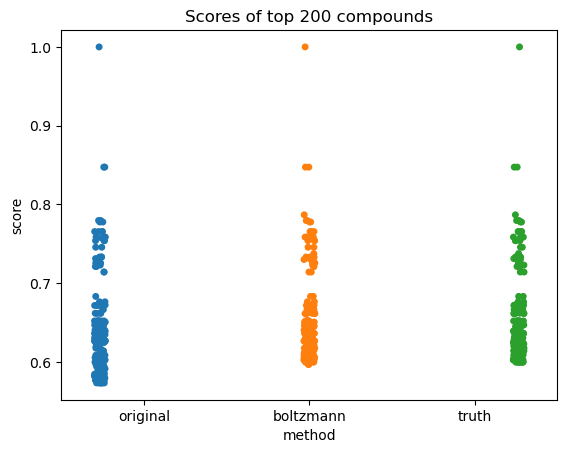

In [56]:
N = 200
ts_compare = pd.concat([ts_df.sort_values("score", ascending=False).head(N).assign(method="original"),
                        ts_boltzmann_df.sort_values("score", ascending=False).head(N).assign(method="boltzmann"),
                        enum_df.sort_values("truth", ascending=False).head(N).rename(columns={"truth": "score"}).assign(method="truth"),
                       ],
                       ignore_index=True)
ax = sns.stripplot(x="method", y="score", hue="method", dodge=True, data=ts_compare)
ax.set_title(f"Scores of top {N} compounds")

Build a merged dataframe with columns for whether each of the original and reweighted found this top molecule

In [47]:
N = 500
df_top_enum = (
    enum_df
    .sort_values("truth", ascending=False)
    .head(N)
)
df_top_orig = (
    ts_df
    .sort_values("score", ascending=False)
    .head(N)
    [["Name"]]
    .assign(original=True)
)
df_top_boltzmann = (
    ts_boltzmann_df
    .sort_values("score", ascending=False)
    .head(N)
    [["Name"]]
    .assign(boltzmann=True)
)
df_top = pd.merge(pd.merge(df_top_enum, df_top_orig, how="left", on="Name"),
                  df_top_boltzmann, how="left", on="Name")
df_top.sample(10)


,SMILES,Name,truth,original,boltzmann
177,COc1cccc2c(=O)n(Cc3nc(CO)n[nH]3)c([C@@H](N)CNC...,389612_521398993_1531037,0.605634,True,True
278,COc1cccc2c(=O)n([C@@H]3CN(C)C[C@H]3O)c(CNC(N)=...,389612_34278490_1464311,0.579710,True,True
63,COc1cccc2c(=O)n(C3CN(CCO)C3)c([C@H](N)CNC(=N)N...,389612_82601602_1576365,0.652174,True,True
119,COc1cccc2c(=O)n([C@H]3CO[C@H]4[C@@H]3OC[C@@H]4...,389612_104600679_1576365,0.625000,True,True
11,COc1cccc2c(=O)n(C3CN(CCO)C3)c([C@@H](N)CNC(N)=...,389612_82601602_1531037,0.765625,True,True
325,COc1cccc2c(=O)n([C@@H]3CC[C@@H](O)[C@@H]3O)c([...,389612_34071169_52986906,0.573529,True,True
258,COc1cccc2c(=O)n(C3CN(CCO)C3)c([C@H](N)CN)nc12,389612_82601602_19363627,0.582090,True,True
197,COc1cccc2c(=O)n([C@@H]3C[C@@H](O)[C@@H](O)C3)c...,389612_146501451_4181821,0.600000,True,True
256,COc1cccc2c(=O)n(C3CN(CCO)C3)c([C@H](N)CCO)nc12,389612_82601602_1742215,0.582090,True,True
260,Cc1cnc2nc([C@@H](N)CNC(N)=O)n([C@@H]3C[C@@H](O...,26441149_146501451_1531037,0.582090,NaN,True


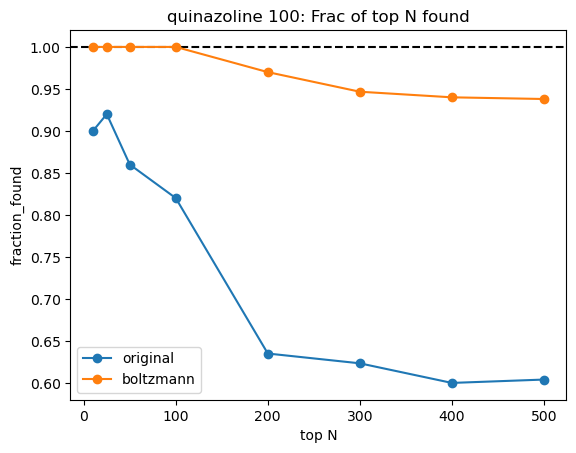

In [57]:
fig, ax = plt.subplots()
top_ns = [10, 25, 50, 100, 200, 300, 400, 500]
for col in ["original", "boltzmann"]:
    ax.plot(top_ns, [df_top.head(n)[col].sum() / n for n in top_ns], label=col, marker="o")
ax.set_xlabel("top N")
ax.set_ylabel("fraction_found")
ax.axhline(1, color="k", linestyle="--", zorder=0)
ax.set_title("quinazoline 100: Frac of top N found")
ax.legend()
pass


Excellent. This is consistent with the publication that reweighting finds more of the top performing molecules.